<a href="https://colab.research.google.com/github/SooinJung/NLP-/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

필요한 라이브러리 설치

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import os

In [4]:
# 사용할 GPU 설정 - 여기서 GPI('0')을 사용하도록 설정
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# 현재 사용 가능한 GPU 리스트를 뽑아옴
gpus = tf.config.experimental.list_physical_devices('GPU')

# GPU가 하나 이상 있는 경우
if gpus:
    try:
        # tensorflow가 필요한 만큼의 메모리만을 할당받도록 첫 번째 GPU의 메모리 증가 옵션 키기
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

## 데이터셋 다운로드
참고 링크: https://csshark.tistory.com/140

### 데이터셋 설명
- 심전도 데이터셋을 토대로 LSTM을 구축하고자 함
- 맨 마지막 140번째 칼럼 = class

In [5]:
# Download the dataset
data = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [7]:
# 마지막 컬럼 전까지는 X로
X = data.values[:,:-1]
# 마지막 컬럼은 Y로 - class를 정답값으로 따로 저장
Y = data.values[:,-1]

# 데이터의 개수가 4998개이며 X는 140개의 피처로 이루어져있다.
print('X shape :',X.shape)
print('Y shape :',Y.shape)

X shape : (4998, 140)
Y shape : (4998,)


## 데이터 전처리
여기서는 그냥 데이터 전처리 과정... 빠르게 skip 해도 좋음

In [9]:
# stratify=Y를 해야 데이터가 골고루 잘 분할이 된다.
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=7, stratify=Y)
print('Train shape :',x_train.shape) #=> Train shape : (3998, 140)
print('Test shape :',x_test.shape) #=> Test shape : (1000, 140)

Train shape : (3998, 140)
Test shape : (1000, 140)


In [10]:
# counter: 빈도수 세는 라이브러리
from collections import Counter

print(Counter(y_train)) #=> Counter({True: 2335, False: 1663})
print(Counter(y_test)) #=> Counter({True: 584, False: 416})

Counter({1.0: 2335, 0.0: 1663})
Counter({1.0: 584, 0.0: 416})


In [11]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) # test set에는 transform만 사용하기 - test set은 fit(학습)하면 안되니까

In [12]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

In [13]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

정상 데이터 시각화

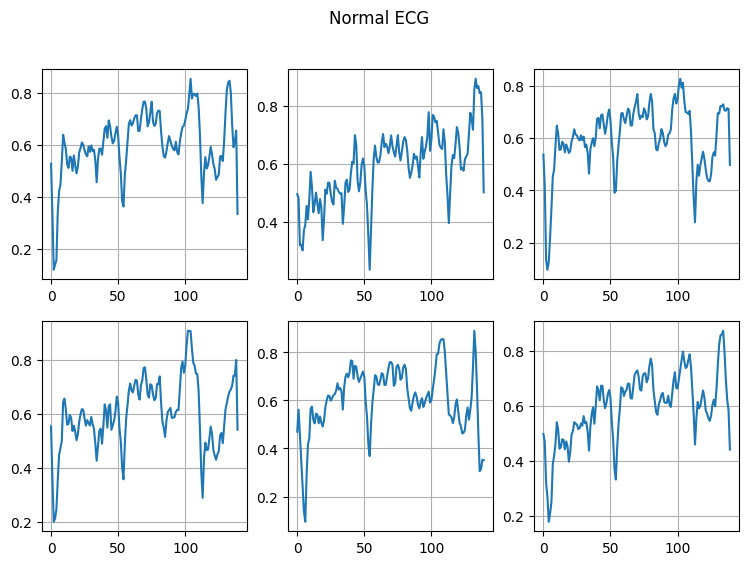

In [15]:
anomalous_x_train = x_train[~y_train]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("anomalous ECG")
ax = ax.ravel() # ax가 3*2차원이기에 for에 1차원으로 만들어 넣기위함
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(anomalous_x_train[idx])), anomalous_x_train[idx])
plt.show()
출처: https://csshark.tistory.com/140 [컴퓨터하는 상어:티스토리]normal_x_train = x_train[y_train]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Normal ECG")
ax = ax.ravel() # ax가 3*2차원이기에 for에 1차원으로 만들어 넣기위함
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(normal_x_train[idx])), normal_x_train[idx])
plt.show()

비정상 데이터 시각화

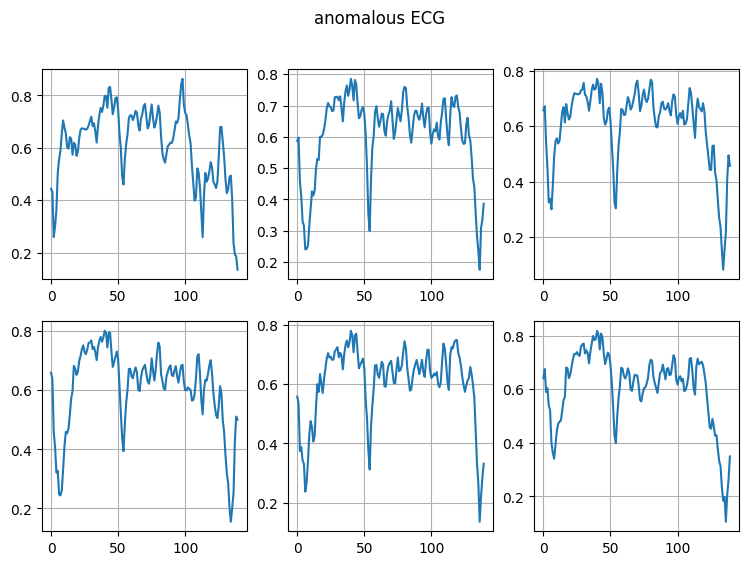

In [16]:
anomalous_x_train = x_train[~y_train]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("anomalous ECG")
ax = ax.ravel() # ax가 3*2차원이기에 for에 1차원으로 만들어 넣기위함
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(anomalous_x_train[idx])), anomalous_x_train[idx])
plt.show()

## LSTM 구조 및 코드 설명
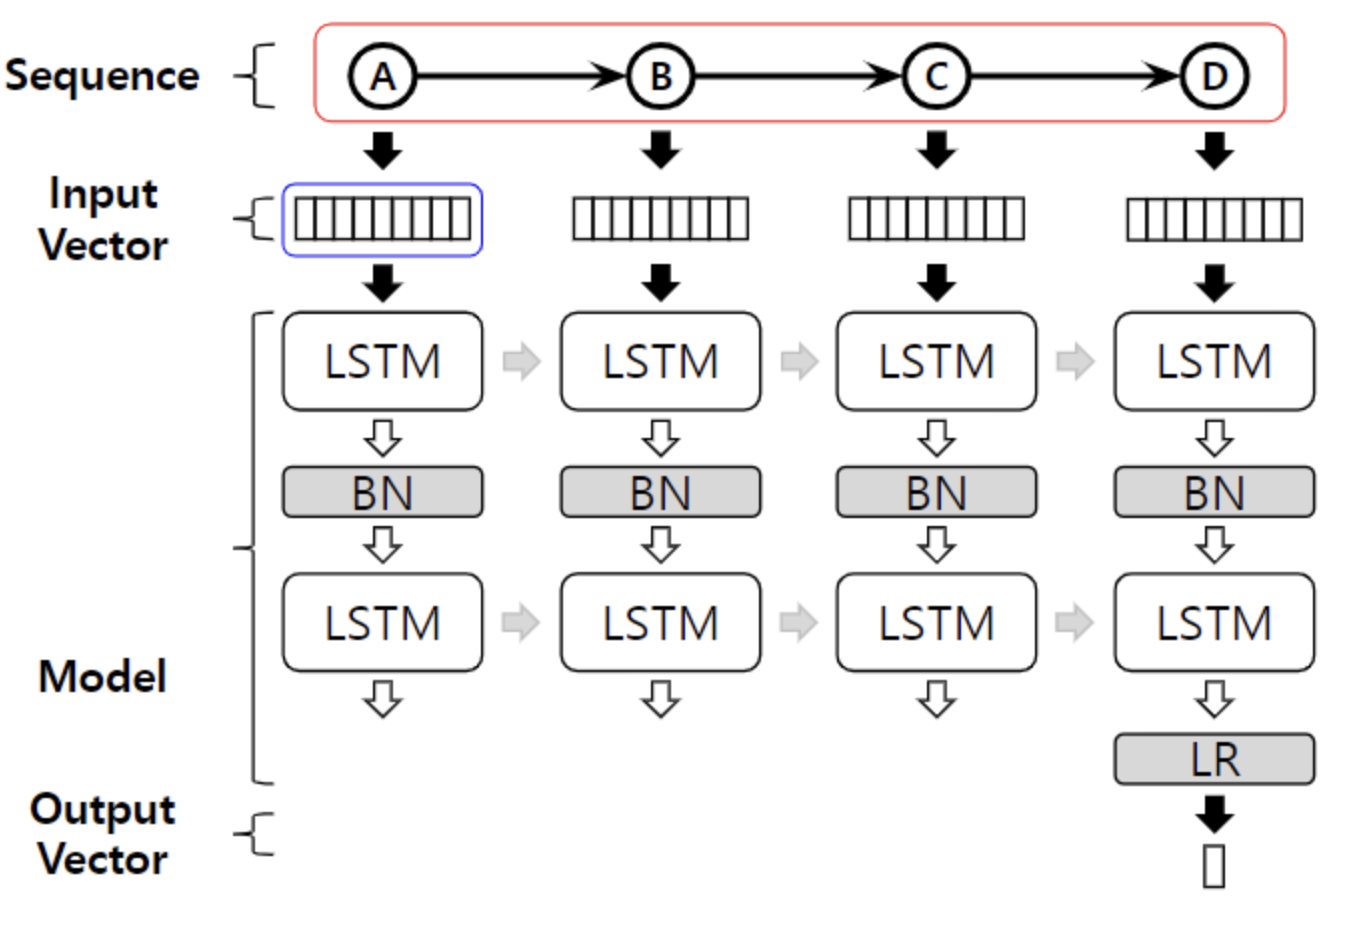

그림에서 붉은색 부분이 LSTM에 입력될 입력 시퀀스이며, 여기 코드에서는 마지막 컬럼을 제외한 심전도 데이터가 이에 해당된다.

위 그림에서 입력 시퀀스들은 아래 파란 박스에 해당하는 Input Vector로 각각 변환됌

그래서 LSTM을 구현할 때 가지고 있는 데이터셋을 Input Vector 형태로 먼저 변환 후에 넣어주어야 한다.

In [18]:
# 차원 확장 - 하나의 특성이 더 추가됌
# RNN은 이런 특정한 차원을 가진 형태의 입력 데이터를 넣어주어야 함
x_train_ex = tf.expand_dims(x_train, axis=2)
x_test_ex = tf.expand_dims(x_test, axis=2)

print('원본 차원 정보 :',x_train.shape)
print('변경된 차원 정보 :',x_train_ex.shape)

# (3998, 140, 1)는 각각 아래의 의미를 가진다.
# (데이터 개수, Sequence 길이, Input Vector 길이

원본 차원 정보 : (3998, 140)
변경된 차원 정보 : (3998, 140, 1)


LSTM 모델 생성 - BLSTM

In [19]:
model = tf.keras.Sequential([
    # return_sequences=True 설정하면 LSTM을 여러개 쌓을 때 hidden state 내용을 볼 수 있다.
    layers.LSTM(100, return_sequences=True, input_shape=(x_train_ex.shape[1], x_train_ex.shape[2])),
    layers.Dropout(0.25),
    layers.Bidirectional(layers.LSTM(100)), # BLSTM
    layers.Dropout(0.25), # for 과적합 방지
    layers.Dense(1, activation='sigmoid')
])

## 모델 설명
1. 세 개의 특성이 있는게 LSTM 구조 - 그래서 위에서 expand.dim 해주어야 했음
2. None(배치 크기, 가변적인 크기라는 뜻), 위에서 return_sequences=True 로 설정했기에 모든 sequences(140)에 대해서 hidden state(100)가 출력됌.
3. dropout은 과적합 방지를 위해 가중치 업데이트를 끄는 것 - 차원에 영향 미치지 않음
4. B~ 가 BLSTM.
5. BLSTM은 위에서 return_sequences를 별도로 설정하지 않았음(디폴트는 False임) - return_sequences=False (기본값): 마지막 시간 단계의 출력만 반환. 출력 형태는 (None, 유닛 수*2)
6. 양방향 구조기 때문에 순방향 hidden 100 + 역방향 hidden 100 = total 200개의 hidden state


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 140, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 140, 100)          0         
                                                                 
 bidirectional (Bidirection  (None, 200)               160800    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 201801 (788.29 KB)
Trainable params: 201801 (788.29 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [21]:
model.compile(loss = 'binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [23]:
training_record = model.fit(x_train_ex, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(x_train_ex, y_train),
                    shuffle=True)

Epoch 1/30
32/32 [==============================] - 10s 87ms/step - loss: 0.4365 - val_loss: 0.0962
Epoch 2/30
32/32 [==============================] - 1s 39ms/step - loss: 0.0832 - val_loss: 0.0626
Epoch 3/30
32/32 [==============================] - 1s 34ms/step - loss: 0.0610 - val_loss: 0.0478
Epoch 4/30
32/32 [==============================] - 1s 37ms/step - loss: 0.0596 - val_loss: 0.0478
Epoch 5/30
32/32 [==============================] - 1s 42ms/step - loss: 0.0525 - val_loss: 0.0412
Epoch 6/30
32/32 [==============================] - 2s 60ms/step - loss: 0.0554 - val_loss: 0.0618
Epoch 7/30
32/32 [==============================] - 2s 50ms/step - loss: 0.0540 - val_loss: 0.0449
Epoch 8/30
32/32 [==============================] - 2s 50ms/step - loss: 0.0446 - val_loss: 0.0403
Epoch 9/30
32/32 [==============================] - 3s 87ms/step - loss: 0.0478 - val_loss: 0.0455
Epoch 10/30
32/32 [==============================] - 2s 60ms/step - loss: 0.0502 - val_loss: 0.0441
Epoch 11

모델 평가

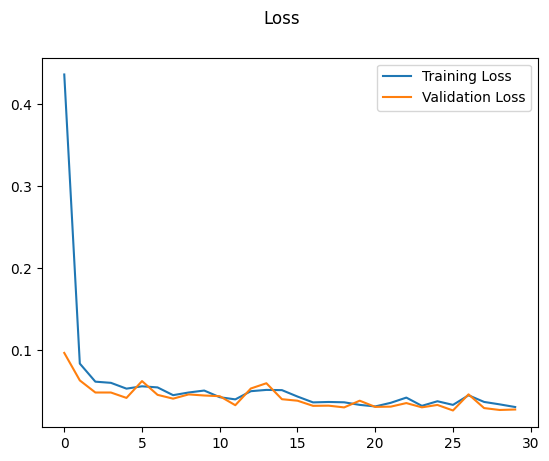

In [24]:
fig, ax = plt.subplots()
plt.plot(training_record.history["loss"], label="Training Loss")
plt.plot(training_record.history["val_loss"], label="Validation Loss")
plt.legend()
fig.suptitle("Loss")
plt.show()

평가하기

In [25]:
pred_proba = model.predict(x_test_ex)

32/32 [==============================] - 2s 11ms/step


In [26]:
# 2차원인 pred_proba를 1차원으로 변경해준다 (1000,1)=>(1000)
pred_proba_1d = pred_proba.reshape(-1)

# 임계치 이상이면 True 미만이면 False를 부여한다.
threshold = 0.5
pred = (pred_proba_1d >= threshold)

In [28]:
# Compute the metrics
accuracy_test_rnn= accuracy_score(y_test, pred)
print(f'Accuracy: {accuracy_test_rnn}')
#=> Accuracy: 0.988

precision_test_rnn=precision_score(y_test, pred)
print(f'Precision = {round(precision_test_rnn,3)}')
#=> Precision = 0.99

recall_test_rnn=recall_score(y_test, pred)
print(f'Recall = {round(recall_test_rnn,3)}')
#=> Recall = 0.99

Accuracy: 0.988
Precision = 0.993
Recall = 0.986
